In [3]:
import os
import glob
import torch.utils.data as td
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

project_dir=os.path.expanduser('~/git/torchseg')
os.chdir(project_dir)

from dataset.fbms_dataset import fbms_dataset
from dataset.cdnet_dataset import cdnet_dataset
from models.motion_stn import motion_stn,motion_net
from models.motionseg.motion_fcn import motion_fcn,motion_fcn_stn
from models.motionseg.motion_unet import motion_unet,motion_unet_stn
from dataset.dataset_generalize import image_normalizations
from utils.torch_tools import get_ckpt_path,load_ckpt
from utils.disc_tools import show_images,show_tensor_list

In [8]:
config={}
config['dataset']='cdnet2014'
config['net_name']='motion_unet'

if config['dataset']=='FBMS':
    config['train_path']='dataset/FBMS/Trainingset'
    config['test_path']=config['val_path']='dataset/FBMS/Testset'
elif config['dataset']=='cdnet2014':
    config['root_path']='dataset/cdnet2014'
else:
    assert False
config['frame_gap']=5
config['log_dir']=os.path.expanduser('~/tmp/logs/motion')
config['epoch']=30
config['init_lr']=1e-4
config['stn_loss_weight']=1.0
config['motion_loss_weight']=1.0
config['pose_mask_reg']=1.0
config['stn_object']='images'
config['note']='fmeasure2000'
config['save_model']=True
config['backbone_name']='vgg16'
config['upsample_layer']=4
config['freeze_layer']=1
config['use_part_number']=200
config['ignore_outOfRoi']=False

normer=image_normalizations(ways='-1,1')
dataset_loaders={}
for split in ['train','val']:
    if config['dataset']=='FBMS':
        xxx_dataset=fbms_dataset(config,split,normalizations=normer)
    else:
        xxx_dataset=cdnet_dataset(config,split,normalizations=normer)
    xxx_loader=td.DataLoader(dataset=xxx_dataset,batch_size=4,shuffle=True,drop_last=False,num_workers=2)
    dataset_loaders[split]=xxx_loader

if config['net_name'] in ['motion_stn','motion_net']:
    model=globals()[config['net_name']]() 
else:
    model=globals()[config['net_name']](config)
# support for cpu/gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

log_dir = os.path.join(config['log_dir'], config['net_name'],
                       config['dataset'], config['note'])
checkpoint_path = get_ckpt_path(log_dir)
model=load_ckpt(model,checkpoint_path)


category badWeather  subcategory blizzard with groundtruth image, roi is 900 to 3949
category badWeather  subcategory snowFall with groundtruth image, roi is 800 to 3649
category nightVideos  subcategory fluidHighway with groundtruth image, roi is 400 to 881
category nightVideos  subcategory bridgeEntry with groundtruth image, roi is 1000 to 1749
category nightVideos  subcategory tramStation with groundtruth image, roi is 500 to 1749
category nightVideos  subcategory winterStreet with groundtruth image, roi is 900 to 1341
category lowFramerate  subcategory tramCrossroad_1fps with groundtruth image, roi is 400 to 649
category lowFramerate  subcategory port_0_17fps with groundtruth image, roi is 1000 to 1999
category PTZ  subcategory continuousPan with groundtruth image, roi is 600 to 1149
category PTZ  subcategory twoPositionPTZCam with groundtruth image, roi is 800 to 1549
category turbulence  subcategory turbulence2 with groundtruth image, roi is 500 to 2499
category turbulence  subca

0 0.29780084 0.5141799 1.0 -1.0


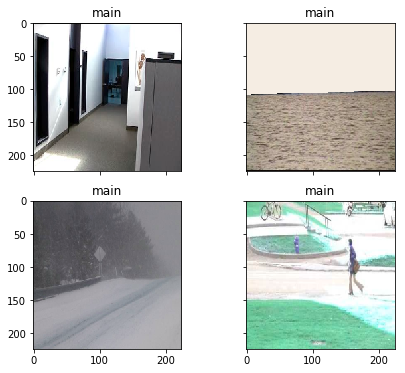

1 0.2981992 0.51401484 1.0 -1.0


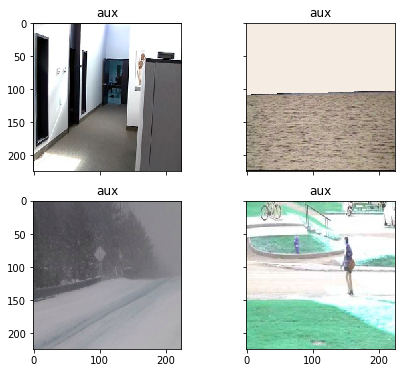

0 0.005919164540816327 0.07670807018792136 1 0


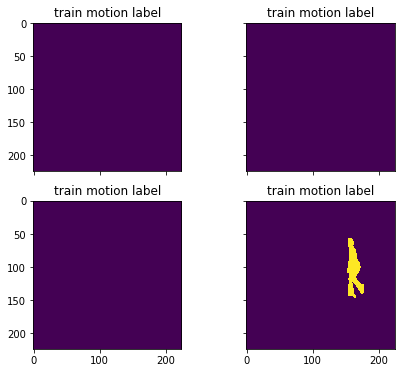

0 0.0 0.0 0 0


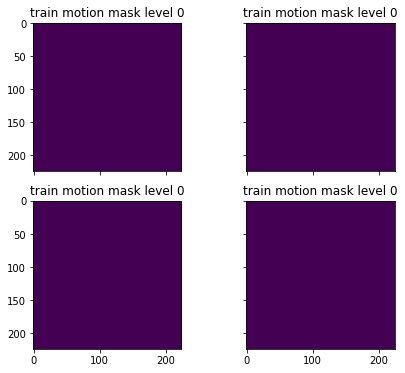

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x2ac5d3841940>>
Traceback (most recent call last):
  File "/data02/jiaxin15/bin/miniconda3/envs/env3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/data02/jiaxin15/bin/miniconda3/envs/env3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/data02/jiaxin15/bin/miniconda3/envs/env3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/data02/jiaxin15/bin/miniconda3/envs/env3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/data02/jiaxin15/bin/miniconda3/envs/env3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as co

0 -0.19871858 0.4211241 1.0 -1.0


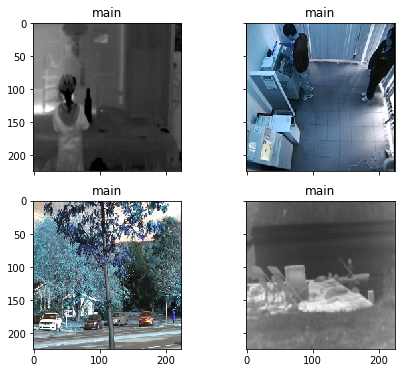

1 -0.1967489 0.4207427 1.0 -1.0


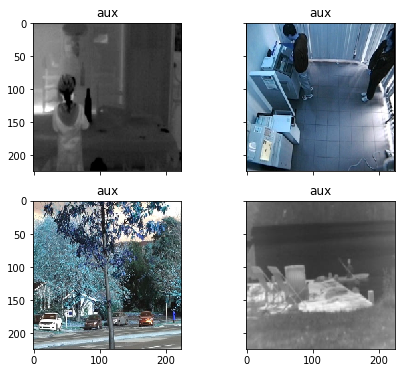

0 0.06219606983418367 0.24151132215977988 1 0


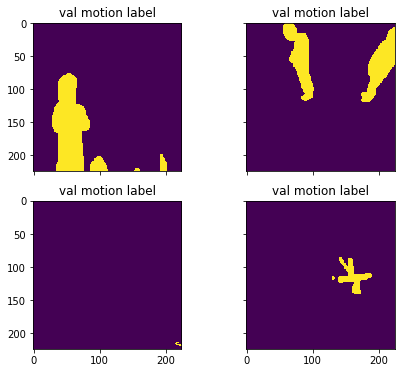

0 0.0 0.0 0 0


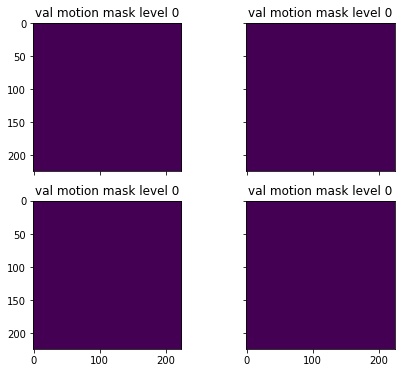

In [10]:
model.eval()
for split in ['train','val']:
    for frames,gt in dataset_loaders[split]:
        images = [torch.autograd.Variable(img.to(device).float()) for img in frames]
        labels=torch.autograd.Variable(gt.to(device).long())
        outputs=model.forward(images)
        
        show_tensor_list(images,['main','aux'],normer)
        show_tensor_list([gt],[split+' motion label'])
        masks=[torch.argmax(x,dim=1,keepdim=True) for x in outputs['masks']]
        show_tensor_list(masks,[split+' motion mask level '+str(idx) for idx,t in enumerate(outputs['masks'])])
        
        break